### Capstone - Final Project

Milestone 3 continues your work with the diaper manufacturing problem, using the same datasets:

- a dataset file SECOM containing 1567 examples, each with 591 features, presented in a 1567 x 591 matrix
- a labels file listing the classifications and date time stamp for each example 

#### Instructions
Create a new notebook and perform each of the following tasks and answer the related questions:

- Build a simple neural networks model
- Build a DNN model
- Build a RNN model
- Summarize your findings with examples.  Explain what the manufacturer should focus on to optimize the diaper manufacturing process.
- Solicit specific feedback on your code (instructions below).

#### Instructions to Solicit Feedback
Write 2-3 questions soliciting feedback on specific aspects on the assignment. For example, if you did something one way but are unsure if there might be a different or better way to do it, ask for feedback on that part. You may submit these questions by commenting out in the code within your .ipynb file or by typing them below your file name in the Your Response box on the Submit Milestone Assignment page. While the questions you submit will have no bearing on your grade, by doing so, you will engage more actively with the assignment and we will also be able to give you pointed feedback.



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# import numpy as np
import sklearn
from sklearn.tree import DecisionTreeClassifier
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras

Couldn't import dot_parser, loading of dot files will not be possible.


In [7]:
# reading data and labels
data = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data', sep=' ', header=None)
labels = pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data',sep=' ', header=None)

In [8]:
# labels
# –1 corresponds to a pass and 1 corresponds to a fail 
labels = labels.iloc[:,:1]
y=labels[0].values

# lets make classes 0 or 1, not -1 or 1
# 0 = pass
# 1 = fail#
y[y == -1] = 0

#### We already did initial data assessment on a previous milestone, so lets skip forward thru data preparation

In [9]:
#We process the missing values first, dropping columns which have a large number of missing values 
#and imputing values for those that have only a few missing values. 
# lets delete columns, that has > 100 missing values
na_data = data.isnull().sum()
bad_features = [int(i) for i in na_data.keys() if na_data[i] > 100]

#removing missing features
data.drop(bad_features, axis=1, inplace=True)

# replace NaN with mean values for each column
data = data.apply(lambda x: x.fillna(x.mean()),axis=0)
print ('The SECOM data set now has {} variables.'.format(data.shape[1]))

The SECOM data set now has 538 variables.


In [10]:
# lets scale features to standard normal distribution
# it is very important to do it before filtering
from sklearn.preprocessing import StandardScaler
sc_x=StandardScaler()
data_scaled=sc_x.fit_transform(data)

#### We still have too many features to handle (more than 500), we need to reduce dimentionality. Will use principal component analysis to retain features, that could explain 80% of variance. I've picked 80%, because it keeps reasonable amount of features (82) . 

In [11]:
# Lets do fitering using Principal component analysis (PCA)
# We will leave most important features, which explain 80% variance
from sklearn.decomposition import PCA
pca = PCA(n_components = 0.90)
pca.fit(data_scaled)
x_reduced = pca.transform(data_scaled)
print ('The filtered data set now has {} variables.'.format(x_reduced.shape[1]))

The filtered data set now has 122 variables.


In [12]:
# splitting into training and testing sets
# we have good amount of records (1500), so the standard 80/20 split should work
import sklearn
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_reduced, y, 
                                             test_size=0.2, 
                                             stratify=y, 
                                             random_state=5)

#### The next step is to deal with imbalance, lets try 3 different strategies:
#### start with using synthetic minority oversampling (SMOTE)

In [16]:
# lets address class imbalance problem
# will use SMOTE (Synthetic Minority Oversampling Technique,)
# !pip install imblearn
# import imblearn
from imblearn.over_sampling import SMOTE
# oversampling
ratio = 0.5
smote = SMOTE(random_state=42)
smox, smoy = smote.fit_sample(X_train, y_train)
print ('Before resampling: \nThe majority/minority class have {} and {} elements respectively.'.format(y_train[y_train == 0].size, y_train[y_train == 1].size))
print ('After oversampling at {}%: \nThe majority/minority class have {} and {} elements respectively.'.format(ratio, smoy[smoy == 0].size, smoy[smoy == 1].size))

Before resampling: 
The majority/minority class have 1170 and 83 elements respectively.
After oversampling at 0.5%: 
The majority/minority class have 1170 and 1170 elements respectively.


#### For the down sampling we only ended up with 83 training samples, that is very few. Will see where we get.

### Classifier statistics helper function
This will print out main classifier statistics, such as accuracy, precision, recall.
In full report mode it will also print a confusion matrix.

In [17]:
#--------------------------------------------
def print_stat(y_test, y_predict_test, text = '', full_report=True):
     
    """ Print prediction model statistics""" 
    cm_train = pd.DataFrame(
        confusion_matrix(y_test, y_predict_test),
        columns=['Predicted pass (negative)', 'Predicted fail (positive)'],
        index=['True pass (negative)', 'True fail (positive)']
    )

    # accuray
    acc_test = accuracy_score(y_test, y_predict_test)
    
    # ROC AUC 
    roc_auc = 0
    try:
        roc_auc = sklearn.metrics.roc_auc_score(y_test, y_predict_test)
    except:
        pass    
    # precision recall    
    p, r, _ , _ = precision_recall_fscore_support(y_test, y_predict_test)
    # precision is the ratio tp / (tp + fp)
    # recall is the ratio tp / (tp + fn)
    
    if full_report:
        print(text)
        print('Confusion matrix:')
        print(cm_train)
        print('\n')
        # tn, fp, fn, tp = confusion_matrix(y_test, y_predict_test).ravel()
        # print(tn, fp, fn, tp)

        print("Accuracy : {:.2f}".format(acc_test))
        print(f'ROC AUC score : {roc_auc:.2f}')
        print(f'Precision : {p[1]:.2f}')
        print(f'Recall : {r[1]:.2f}\n')


    else:
        print(f'{text} ACC={acc_test:.2f} ROCAUC={roc_auc:.2f} PRE={p[1]:.2f} RECALL={r[1]:.2f}')


### Plot neural network diagnostics helper function
This function will help us to plot learning curves for train and test data over time

In [19]:
# ----------------------------------------------------------------------------
def summarize_diagnostics(history):
    """ Plot diagnostic learning curves
    
    history.history: attribute is a record of training loss values and metrics values at successive epochs, 
            as well as validation loss values and validation metrics values (if applicable).
    """
    # plot loss
    # plt.subplot(211)
    # plt.title('Cross Entropy Loss')
    # plt.plot(history.history['loss'], color='blue', label='train')
    # plt.plot(history.history['val_loss'], color='orange', label='test')
    # plt.legend(loc="upper right")
    # plt.xlabel('Epochs')
    # plt.xlabel('Loss')
    # plt.show()
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    plt.legend(loc="lower right")
    plt.xlabel('Epochs #')
    plt.ylabel('Accuracy')
    
    plt.show()

### Simple neural network.
The simplest network is a preceptron, it has only on input and one output layer. No hidden layers.
We will use binary_crossentropy as a loss function since we only have binary classification.
Will run it for 5 epochs and print out statistics.

 ----------->>> SIMPLE NN  Classifier <<<--------------
Epoch 1/5
74/74 [==============================] - 0s 664us/step - loss: 1.0082 - accuracy: 0.4902
Epoch 2/5
74/74 [==============================] - 0s 605us/step - loss: 0.7876 - accuracy: 0.5983
Epoch 3/5
74/74 [==============================] - 0s 584us/step - loss: 0.6678 - accuracy: 0.6718
Epoch 4/5
74/74 [==============================] - 0s 594us/step - loss: 0.5942 - accuracy: 0.7132
Epoch 5/5
74/74 [==============================] - 0s 608us/step - loss: 0.5452 - accuracy: 0.7462
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  123       
Total params: 123
Trainable params: 123
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if you

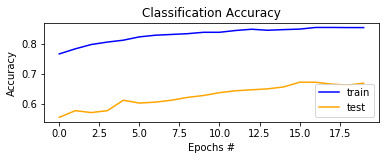

In [20]:
print (' ----------->>> SIMPLE NN  Classifier <<<--------------')


train_labels = smoy
train_x = smox 


model = keras.Sequential([
    # keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



model.fit(train_x, train_labels, epochs=5)

print(model.summary())

# make class predictions with the model
y_test_pred = model.predict_classes(X_test)

print_stat(y_test_pred, y_test, full_report=False, text='SIMPLE NN  ')
print_stat(y_test_pred, y_test, full_report=True, text='SIMPLE NN  ')

history = model.fit(train_x, train_labels, validation_data=(X_test, y_test), epochs=20, verbose=0)
summarize_diagnostics(history)

We've achieved a mediocre accuracy of 53%.
We have to keep in mind, that our classes are biased, we have 90% of 0s. That means that a random classifier will easily achieve almost 50% accuracy, since we are dominated by one class.

### DNN.
Lets add two hidden layers with 50 elements. And run it for 5 epochs.

Epoch 1/5
74/74 [==============================] - 0s 877us/step - loss: 0.4749 - accuracy: 0.7889
Epoch 2/5
74/74 [==============================] - 0s 818us/step - loss: 0.2179 - accuracy: 0.9397
Epoch 3/5
74/74 [==============================] - 0s 790us/step - loss: 0.1166 - accuracy: 0.9765
Epoch 4/5
74/74 [==============================] - 0s 771us/step - loss: 0.0594 - accuracy: 0.9927
Epoch 5/5
74/74 [==============================] - 0s 809us/step - loss: 0.0319 - accuracy: 0.9974
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             multiple                  6150      
_________________________________________________________________
dense_20 (Dense)             multiple                  2550      
_________________________________________________________________
dense_21 (Dense)             multiple                  51        
Total params: 8,751
T

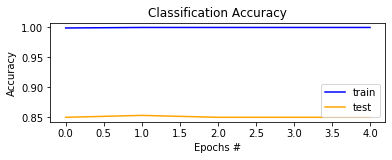

In [28]:
train_labels = smoy
train_x = smox # X_train_upsampled

# TensorFlow and tf.keras

model = keras.Sequential([
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(50, activation='relu'),
    
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.fit(train_x, train_labels, epochs=5)
print(model.summary())

# make class predictions with the model
y_test_pred = model.predict_classes(X_test)

print_stat(y_test_pred, y_test, full_report=False, text='SIMPLE NN  ')
print_stat(y_test_pred, y_test, full_report=True, text='SIMPLE NN  ')

history = model.fit(train_x, train_labels, validation_data=(X_test, y_test), epochs=5, verbose=0)
summarize_diagnostics(history)


The accuracy is much better, around 85%. However precision and recall is very small, and our underrepresented class is rarely well predicted.
### RNN, recursive network.
Lets build a simple RNN, with one recurrent layer of 50 units, followed  by  LSTM layer with size 50. 
Note, to feed the data to RNN we need to reshape our data to represented batch/timesteps/feature. We will use only one timestamp. 


In [37]:
print (' ----------->>> RNN  Classifier <<<--------------')
train_labels = smoy
train_x = smox # X_train_upsampled


# reshape to  [batch, timesteps, feature].
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


model = keras.Sequential()
model.add(keras.layers.SimpleRNN(50, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))

# Add a LSTM layer with 128 internal units.
model.add(keras.layers.LSTM(50))

# Add a Dense layer with 10 units.
#model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# compile RNN model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print RNN model summary
print(model.summary())

model.fit(train_x, train_labels, epochs=10)


# make class predictions with the model
y_test_pred = model.predict_classes(X_test_reshaped)

print_stat(y_test_pred, y_test, full_report=False, text='RNN  ')
print_stat(y_test_pred, y_test, full_report=True, text='RNN  ')



 ----------->>> RNN  Classifier <<<--------------
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_8 (SimpleRNN)     (None, 1, 50)             8650      
_________________________________________________________________
lstm_8 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 51        
Total params: 28,901
Trainable params: 28,901
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
74/74 [==============================] - 0s 2ms/step - loss: 0.5632 - accuracy: 0.7444
Epoch 2/10
74/74 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.8714
Epoch 3/10
74/74 [==============================] - 0s 2ms/step - loss: 0.2134 - accuracy: 0.9397
Epoch 4/10
74/74 [============

Again, accuracy is pretty good, but out prediction for failed samples ("positive" class) is not very good.

### Conclusions
For our project we need to be doing quality control, successfully detecting faulty products.
For that we need to minimize  false negative (the items that are faulty, but are predicted as good).
Also, we need to minimize false positive (the products, that are actually good quality, but predicted as faulty).
So we are after maximizing recall and precision. 
Out of current classifier, RNN and DNN demonstrated comparable quality, but still tending to mispredict true positive of under-represented class. DNN runs a little bit faster.


